In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
%matplotlib inline

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')


!pip install wordcloud
from wordcloud import WordCloud

!pip install tweet-preprocessor
import preprocessor as p

from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading Datasets

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#sentiment140 dataset
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']
dataset = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv', encoding= encoding , names=col_names)


In [4]:
dataset.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df = dataset.copy().sample(6000, random_state=42) #random 6000 tweets
df["label"] = 0
df = df[['text', 'label']]
df.dropna(inplace=True)
df.head()

,text,label
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0
750,"@misstoriblack cool , i have no tweet apps fo...",0
766711,@TiannaChaos i know just family drama. its la...,0
285055,School email won't open and I have geography ...,0
705995,upper airways problem,0


In [6]:
# dataset of depresses tweets
col_names = ['id', 'text']
df2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/depressive_tweets_processed.csv', sep = '|', header = None, usecols = [0,5], nrows = 3200, names=col_names)
df2.head()

,id,text
0,989292962323615744,The lack of this understanding is a small but ...
1,989292959844663296,i just told my parents about my depression and...
2,989292951716155392,depression is something i don't speak about ev...
3,989292873664393218,Made myself a tortilla filled with pb&j. My de...
4,989292856119472128,@WorldofOutlaws I am gonna need depression med...


In [7]:
# add `label` colum with value 1's
df2['label'] = 1
df2 = df2[['text', 'label']]
df = pd.concat([df,df2]) # merge the dataset on normal tweets and depressive tweets
df = df.sample(frac=1)  # shuffle the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8345 entries, 357553 to 736965
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8313 non-null   object
 1   label   8345 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 195.6+ KB


Data Preprocessing

In [8]:
contractions = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/contractions.json', typ='series')
contractions = contractions.to_dict()

c_re = re.compile('(%s)' % '|'.join(contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return contractions[match.group(0)]
    return c_re.sub(replace, text)

In [9]:
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        tweet = tweet.lower()
        tweet = BAD_SYMBOLS_RE.sub(' ', tweet)
        tweet = p.clean(tweet)
        
        #expand contraction
        tweet = expandContractions(tweet)

        #remove punctuation
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

        #stop words
        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet) 
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        tweet = ' '.join(filtered_sentence)
        
        cleaned_tweets.append(tweet)
        
    return cleaned_tweets

In [10]:
X = clean_tweets([tweet for tweet in df['text']])

Analyzing words

In [11]:
depressive_tweets = [clean_tweets([t for t in df2['text']])]
depressive_words = ' '.join(list(map(str, depressive_tweets)))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)

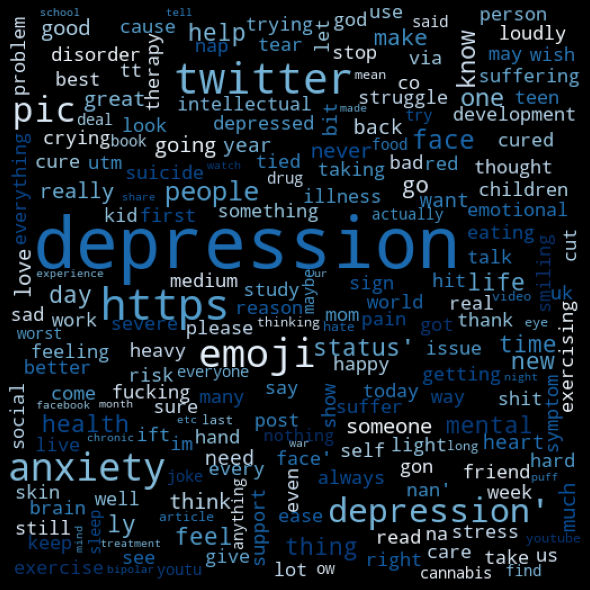

In [12]:
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


Here we can see the words that are indicative of depression in these tweets: depression, anxiety, suffering, illness, drug etc

Tokenization

In [13]:
MAX_NUM_WORDS = 10000
tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
word_vector = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size   # num of unique tokens

18174

In [14]:
MAX_SEQ_LENGTH = 140
input_tensor = pad_sequences(word_vector, maxlen=MAX_SEQ_LENGTH)
input_tensor.shape

(8345, 140)

TF- IDF

In [15]:
corpus = df['text'].values.astype('U')
tfidf = TfidfVectorizer(max_features = MAX_NUM_WORDS) 
tfidf_tensor = tfidf.fit_transform(corpus)
tfidf_tensor.shape

(8345, 10000)

Naive Bayes Model

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, df.label, test_size=0.3, random_state = 42)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(x_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [17]:
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, digits=5))

accuracy 0.9217252396166135
              precision    recall  f1-score   support

           0    0.90488   0.99612   0.94831      1805
           1    0.98646   0.72961   0.83882       699

    accuracy                        0.92173      2504
   macro avg    0.94567   0.86287   0.89356      2504
weighted avg    0.92765   0.92173   0.91775      2504



SVM Model

In [18]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_tensor, df['label'].values, test_size=0.3,)
svm_model = SVC()
svm_model.fit(x_train, y_train)

SVC()

In [19]:
predictions = svm_model.predict(x_test)

In [20]:
accuracy_score(y_test, predictions)

0.9936102236421726

In [21]:
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9913    1.0000    0.9956      1818
           1     1.0000    0.9767    0.9882       686

    accuracy                         0.9936      2504
   macro avg     0.9956    0.9883    0.9919      2504
weighted avg     0.9937    0.9936    0.9936      2504

